In [36]:
import lightgbm as lgb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 【練習問題】健診データによる肝疾患判定

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


## 探索的データ分析

In [4]:
train.shape

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        891 non-null    int64  
 1   Age       891 non-null    int64  
 2   Gender    891 non-null    object 
 3   T_Bil     891 non-null    float64
 4   D_Bil     891 non-null    float64
 5   ALP       891 non-null    float64
 6   ALT_GPT   891 non-null    float64
 7   AST_GOT   891 non-null    float64
 8   TP        891 non-null    float64
 9   Alb       891 non-null    float64
 10  AG_ratio  887 non-null    float64
 11  disease   891 non-null    int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 83.7+ KB


## エンコーディング

In [7]:
label_encoder = LabelEncoder()
train['Gender'] = label_encoder.fit_transform(train['Gender'])

In [8]:
train.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,1,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,0,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,1,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,1,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,0,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


## 特徴量の抽出

In [11]:
trainX = train.iloc[:, 1:11]

In [13]:
trainX.head(1)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,60,1,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01


In [15]:
y = train.iloc[:, 11:12]

In [16]:
y.head(1)

,disease
0,1


In [17]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)# 学習データを4分割し、うち1つを検証データとする

#  学習データセットと検証データセットにそれぞれ振り分けた要素番号のリストを保持するリスト（つまり二元リスト）の1番目要素を取得
tr_idx, va_idx = list(kf.split(trainX, y))[0]
tr_x, va_x = trainX.iloc[tr_idx], trainX.iloc[va_idx]
tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

## lightgbmモデルの作成

In [18]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(tr_x, tr_y)
lgb_eval = lgb.Dataset(va_x, va_y)

In [20]:
# ハイパーパラメータの設定
params = {'objective': 'binary', 
          'learning_rate': 0.1,
          'seed': 71, 
          'verbose': 0, 
          'metrics': 'auc', 
          'colsample_bytree': 0.8, 
          'max_depth': 3, 
          'min_data_in_leaf': 2, 
          'subsample': 0.8}
num_round = 10000

In [21]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, 
                  lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval], 
                  early_stopping_rounds=100,
                  verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.974187	valid's auc: 0.884662
[100]	train's auc: 0.991789	valid's auc: 0.894686
[150]	train's auc: 0.998232	valid's auc: 0.905072
[200]	train's auc: 0.999767	valid's auc: 0.91715
[250]	train's auc: 0.999991	valid's auc: 0.91868
[300]	train's auc: 1	valid's auc: 0.919887
[350]	train's auc: 1	valid's auc: 0.924638
[400]	train's auc: 1	valid's auc: 0.925845
[450]	train's auc: 1	valid's auc: 0.926973
[500]	train's auc: 1	valid's auc: 0.92657
[550]	train's auc: 1	valid's auc: 0.929388
[600]	train's auc: 1	valid's auc: 0.928744
[650]	train's auc: 1	valid's auc: 0.929549
[700]	train's auc: 1	valid's auc: 0.928986
[750]	train's auc: 1	valid's auc: 0.929066
Early stopping, best iteration is:
[666]	train's auc: 1	valid's auc: 0.930354


## モデルの性能を評価する

In [22]:
va_pred = model.predict(va_x)

In [24]:
max(va_pred)

0.9999999871046351

In [25]:
min(va_pred)

1.962576254660993e-06

In [26]:
va_pred_binary = (model.predict(va_x) > 0.5).astype(int) # 確率0.5以上なら1とする

### 混同行列をデータフレーム化

In [29]:
# 混同行列の作成
cm = confusion_matrix(y_true=va_y, y_pred=va_pred_binary)

In [30]:
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])

In [31]:
df_cm

,predict_Positive,predict_Negative
actual_Positive,85,23
actual_Negative,13,102


### AUC計測

In [34]:
roc = roc_curve(va_y, va_pred_binary, drop_intermediate=False)

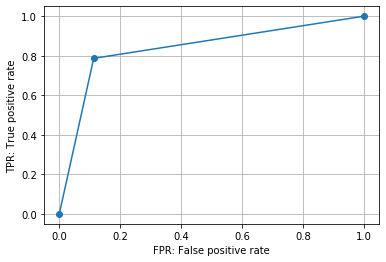

In [37]:
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [38]:
roc_auc = roc_auc_score(va_y, va_pred_binary)
print(f'roc_auc_score: {roc_auc:.4f}')

roc_auc_score: 0.8370
